# Time Series Forecasting 

## Table of content
- Imports and Data Loading 
- Custom Functions, Classes, and Transformrs
- Data Statistics, and Test Splitting
- Data Cleaning
- Feature Engineering
- Modeling
- Results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, BaseEstimator,RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from statsmodels.tsa.arima.model import ARIMA
from sklearn.multioutput import MultiOutputRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv("projectdata.xlsx - sheet 1.csv")

### Custom Functions, Classes, and Transformrs

In [3]:
def describe_data(data = None):
    description = pd.DataFrame()
    description["Count"] = data.count()
    description["DType"] = data.dtypes
    description["# Unique"] = data.nunique()
    description["# Missing"] = data.isna().sum()
    description["% Missing"] = round(description["# Missing"] / (description["Count"]+data.isna().sum()) * 100,2)

    desc = data.describe(include="all").T
    description["Mean"] = desc["mean"]
    description["STD"] = desc["std"]
    description["Min"] = desc["min"]
    description["max"] = desc["max"]    

    return description

In [4]:
def get_outliers_zscore(data): 
    scores=pd.DataFrame()
    for feature in data.columns:
        scores["z-score " + feature] = (data[feature] - data[feature].mean()) / data[feature].std()
    return scores

In [5]:
def cal_moving_average(X, span, center=True, min_periods=None):
    if not min_periods:
        min_periods = int(span/2)
    return X.rolling(window=span, center=center, min_periods=min_periods).mean()

In [6]:
def cal_EMA(X, span):
    return X.ewm(span=span, adjust=False).mean()

In [7]:
def cal_DEMA(X, span):
    ema1 = cal_EMA(X, span)
    return 2 * ema1 - ema1.ewm(span=span, adjust=False).mean()

In [8]:
def cal_TEMA(X, span):
    ema1 = cal_EMA(X, span)
    ema2 = cal_EMA(ema1, span)
    ema3 = cal_EMA(ema2, span)
    return 3 * ema1 - 3 * ema2 + ema3

In [9]:
def plot_sales_and_moving_averages(data, moving_averages, products, cities, title='Sales and Moving Averages', label="SMA"):
    
    fig, axs = plt.subplots(len(products), len(cities), figsize=(15, 15))
    fig.suptitle(title, fontsize=16)
    
    for i, product in enumerate(products):
        for j, city in enumerate(cities):
            ax = axs[i, j]
            col = f'sales_{product}_{city}'
    
            ax.scatter(data.index, data[col], label='Sales', color='blue', s=10, alpha=0.6)
            ax.plot(moving_averages[col], label=label, color='orange', linewidth=2)
            
            ax.set_title(f'{product} in {city}'.upper())
            ax.set_xlabel('Date')
            ax.set_ylabel('Sales')
            ax.tick_params(rotation=45)
            ax.legend()
            ax.grid()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [10]:
def plot_periodogram(ts, detrend='linear', smooth=None, ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    
    if smooth:
        spectrum = pd.Series(spectrum).rolling(window=smooth, center=True).mean()

    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax


In [11]:
def seasonal_plot(data, time_component, aggfunc='mean', ax=None):
    df = data.copy()
    df["dayofweek"] = df.index.dayofweek
    df["week"] = df.index.isocalendar().week.astype(int)
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["dayofyear"] = df.index.dayofyear
    df["semiweekly"] = df.index.dayofyear // 14 


    grouped_data = df.groupby(time_component).agg(aggfunc)
    
    sales_columns = [col for col in df.columns if "sales" in col]
    grouped_data = grouped_data[sales_columns]
    
    melted_data = grouped_data.melt(var_name="Sales Feature", value_name="Sales", ignore_index=False)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 5)) 
    
    sns.lineplot(data=melted_data, x=melted_data.index, y="Sales", hue="Sales Feature", ax=ax)
    
    if time_component == "month":
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                            'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
    
    elif time_component == "dayofweek":
        ax.set_xticks(range(7))
        ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)

    elif time_component == "semiweekly":
        ax.set_xticks(np.arange(melted_data.index.min(), melted_data.index.max(), step=1))
        ax.set_xticklabels([f'Semiweek {i}' for i in range(len(ax.get_xticks()))], rotation=45)
    
    ax.set_title(f"Seasonal Plot of Sales by {time_component.capitalize()}")
    ax.set_xlabel(time_component.capitalize())
    ax.set_ylabel("Sales")
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
    plt.subplots_adjust(right=0.8)  

    return ax

In [12]:
def plot_correlogram(data, column, lags=30):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    plot_pacf(data[column].dropna(), lags=lags, ax=axes[1], title=f'Partial Autocorrelation: {column}')

    plot_acf(data[column].dropna(), lags=lags, ax=axes[0], title=f'Autocorrelation: {column}')
    
    plt.tight_layout()
    plt.show()

In [13]:
def plot_lags(x, y, lags=8, nrows=2, filter_zeros=True):
    ncols = int(np.ceil(lags / nrows))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))
    axs = axs.flatten()  

    for lag in range(1, lags + 1):
        ax = axs[lag - 1]
        
        x_lagged = x.shift(lag)
        
        valid_idx = (~x_lagged.isna()) & (~y.isna())
        if filter_zeros:
            valid_idx = valid_idx & (x_lagged != 0) & (y != 0)
        
        x_lagged = x_lagged[valid_idx]
        y_valid = y[valid_idx]

        ax.scatter(x_lagged, y_valid, alpha=0.5)

        model = Ridge(alpha=1e-5)
        model.fit(x_lagged.values.reshape(-1, 1), y_valid)
        
        pred = model.predict(x_lagged.values.reshape(-1, 1))
        ax.plot(x_lagged, pred, color='red', linewidth=2)

        corr_coef = np.corrcoef(x_lagged, y_valid)[0, 1]
        ax.annotate(f'{corr_coef:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    fontsize=12, ha='left', va='top',
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

        ax.set_title(f'Lag {lag}')
        ax.set_xlabel(x.name)
        ax.set_ylabel(y.name)
    
    plt.tight_layout()
    plt.show()


In [14]:
def create_fourier_features(df, column, period, n_harmonics):
    for i in range(1, n_harmonics + 1):
        df[f'sin_{column}_{i}'] = np.sin(2 * np.pi * i * df[column] / period)
        df[f'cos_{column}_{i}'] = np.cos(2 * np.pi * i * df[column] / period)
    return df

In [15]:
def add_day_of_week_onehot(df, date_col='date', drop_first=True):
    df['day_of_week'] = df[date_col]

    encoder = OneHotEncoder(drop='first' if drop_first else None, sparse_output=False)
    day_of_week_encoded = encoder.fit_transform(df[['day_of_week']])

    if drop_first:
        encoded_columns = [f'day_of_week_{i}' for i in range(1, 7)]
    else:
        encoded_columns = [f'day_of_week_{i}' for i in range(7)]

    encoded_df = pd.DataFrame(day_of_week_encoded, columns=encoded_columns, index=df.index)
    df_with_dummies = pd.concat([df, encoded_df], axis=1)

    df_with_dummies.drop(columns=['day_of_week'], inplace=True)

    return df_with_dummies

In [16]:
def lag(data, max_lag=10, lags=None):
    df = data.copy()
    lagged_features = pd.DataFrame()
    columns = df.columns
    for col in columns:
        for lag in range(1, max_lag + 1):
            lagged_features[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return lagged_features

In [17]:
def create_lag_features(data, lags=[1, 7]):
    df = data.copy()
    lagged_features = pd.DataFrame()

    for col in df.columns:
        for lag in lags:
            lagged_features[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    return lagged_features

In [18]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MAE: {train_mae}")
    print(f"Testing MAE: {test_mae}")
    print(f"Training R-squared: {train_r2}")
    print(f"Testing R-squared: {test_r2}")


## <----Addon to the task---->

In [19]:
def plot_past_and_predictions(past_values, predicted_values, start_date=None, target_names=None):
    # Ensure past_values and predicted_values are numpy arrays
    past_values = np.array(past_values)
    predicted_values = np.array(predicted_values)

    # Get lengths of past and future values
    n_past = past_values.shape[0]
    n_future = predicted_values.shape[0]

    # Generate date ranges based on start_date
    start_date = pd.to_datetime(start_date)
    past_dates = pd.date_range(start=start_date, periods=n_past, freq='D')
    future_dates = pd.date_range(start=past_dates[-1] + pd.Timedelta(days=1), periods=n_future, freq='D')

    # Define plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    axes = axes.ravel()  # Flatten for easy indexing

    for i in range(9):
        # Check if the target index exists in past_values and predicted_values
        if i < past_values.shape[1] and i < predicted_values.shape[1]:
            # Plot past values
            axes[i].plot(past_dates, past_values[:, i], label='Past', color='black')
            
            # Plot predicted values
            axes[i].plot(future_dates, predicted_values[:, i], label='Prediction', color='red', linestyle='--')
        
            # Set title and labels using target names if provided
            if target_names is not None and len(target_names) == 9:
                axes[i].set_title(target_names[i])  # Set custom title from target names
            else:
                axes[i].set_title(f"City/Product {i + 1}")  # Fallback title

            axes[i].set_ylabel("Sales")
            axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis tick labels for better readability

    # General plot settings
    fig.suptitle("Past and Predicted Sales per City/Product", fontsize=16)

    # Set the x-axis label with start date, if provided
    x_label = f"Date (Start Date: {start_date.strftime('%Y-%m-%d')})" if start_date else "Index"
    fig.text(0.5, 0.04, x_label, ha='center', fontsize=12)

    # Create a global legend
    handles, labels = axes[0].get_legend_handles_labels()  # Get legend handles and labels from the first subplot
    fig.legend(handles, labels, loc='upper right', fontsize='medium', title="Legend")  # Global legend

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout for title and x-axis space
    plt.show()

In [20]:
class GroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent', handle_unknown='value_error', impute='null'):
        self.strategy = strategy
        self.handle_unknown = handle_unknown
        self.impute = impute
        self.group_stats = None
        self.global_stat = None

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns
        self.target_col = X.columns[0]
        self.group_col = X.columns[1]
        self.group_stats = self._calculate_group_stats(X)
        self.groups = set(self.group_stats.index)
        
        if self.strategy == 'most_frequent':
            self.global_stat = X[self.target_col].mode()[0]
        elif self.strategy == 'mean':
            self.global_stat = X[self.target_col].mean()
        elif self.strategy == 'median':
            self.global_stat = X[self.target_col].median()
        elif self.strategy == 'min':
            self.global_stat = X[self.target_col].min()
        elif self.strategy == 'max':
            self.global_stat = X[self.target_col].max()
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        
        return self

    def _calculate_group_stats(self, X):
        if self.strategy == 'most_frequent':
            return X.groupby(self.group_col)[self.target_col].agg(lambda x: x.mode()[0])
        elif self.strategy == 'mean':
            return X.groupby(self.group_col)[self.target_col].mean()
        elif self.strategy == 'median':
            return X.groupby(self.group_col)[self.target_col].median()
        elif self.strategy == 'min':
            return X.groupby(self.group_col)[self.target_col].min()
        elif self.strategy == 'max':
            return X.groupby(self.group_col)[self.target_col].max()
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

    def _handle_unknown_groups(self, row):
        if row[self.group_col] not in self.groups:
            if self.handle_unknown == 'value_error':
                raise ValueError(f"Unknown group encountered: {row[self.group_col]}")
            elif self.handle_unknown == 'force':
                return self.global_stat if pd.isnull(row[self.target_col]) else row[self.target_col]
            elif self.handle_unknown == 'ignore':
                return row[self.group_col] if pd.isnull(row[self.target_col]) else row[self.target_col]
        return None

    def _impute_values(self, row):
        unknown_group_handling = self._handle_unknown_groups(row)
        
        if unknown_group_handling is not None:
            return unknown_group_handling

        if self.impute == 'null':
            return self.group_stats[row[self.group_col]] if pd.isnull(row[self.target_col]) else row[self.target_col]
        elif self.impute == 'all':
            return self.group_stats[row[self.group_col]]
    
    def transform(self, X):
        imputed_X = X.copy()
        imputed_X[self.target_col] = imputed_X.apply(self._impute_values, axis=1)
        
        return imputed_X
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_in_

In [21]:
class ZscoreCapOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        self.mean_ = X.mean()
        self.std_ = X.std()
        self.lower_cap = X.quantile(0.05)
        self.upper_cap = X.quantile(0.95)
        return self

    def transform(self, X):
        for col in X.columns:
            z_score = (X[col] - self.mean_[col]) / self.std_[col]
            X.loc[z_score > self.threshold, col] = self.upper_cap[col]
            X.loc[z_score < -self.threshold, col] = self.lower_cap[col]
        return X 

In [22]:
class IQROutlierCapping(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.feature_names_in_ = X.columns
        
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        
        self.lower_bound = Q1 - (self.threshold * IQR)
        self.upper_bound = Q3 + (self.threshold * IQR)
        
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        
        X_capped = X.apply(lambda col: np.where(
            col < self.lower_bound[col.name], self.lower_bound[col.name],
            np.where(col > self.upper_bound[col.name], self.upper_bound[col.name], col)
        ), axis=0)

        return X_capped

        
    def get_feature_names_out(self, input_features=None):
        return np.array([f"{input_features[i]}_capped" for i in range(len(input_features))])

In [23]:
class StringDataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, length_threshold=(2, 50), impute=True, strategy="most_frequent"):
        self.strategy = strategy
        self.impute = impute
        self.length_threshold = length_threshold

    def fit(self, X, y=None):
        self.feature_names_in_ =  X.columns
        return self

    def transform(self, X):
        X_cleaned = pd.DataFrame(X)

        non_ascii_mask = X_cleaned.apply(lambda col: col.str.contains(r'[^\x00-\x7F]', regex=True, na=False) if col.dtype == 'object' else False, axis=0)
        X_cleaned[non_ascii_mask] = np.nan

        unusual_length_mask = X_cleaned.apply(
            lambda col: (col.str.len() < self.length_threshold[0]) | (col.str.len() > self.length_threshold[1]) if col.dtype == 'object' else False,
            axis=0
        )
        X_cleaned[unusual_length_mask] = np.nan
        X_cleaned = X_cleaned.apply(lambda x : x.str.strip().str.lower(),axis=0)


        if self.impute:
            imputer = SimpleImputer(strategy=self.strategy)
            X_cleaned = pd.DataFrame(imputer.fit_transform(X_cleaned), columns=X_cleaned.columns)

        return X_cleaned

    def get_feature_names_out(self, input_features=None):
        return input_features

In [24]:
class GenerateMultipleOutputs(BaseEstimator, TransformerMixin):
    def __init__(self, target, outputs, strategy="mean", index=None):
        self.outputs = outputs
        self.target = target
        self.strategy = strategy
        self.index = index

    def fit(self, X, y=None):
        if self.strategy == "mean":
            self.aggregated_data = X.groupby([self.index] + self.outputs, as_index=False)[self.target].mean()
        elif self.strategy == "median":
            self.aggregated_data = X.groupby([self.index] + self.outputs, as_index=False)[self.target].median()
        elif self.strategy == "sum":
            self.aggregated_data = X.groupby([self.index] + self.outputs, as_index=False)[self.target].sum()
        elif self.strategy == "min":
            self.aggregated_data = X.groupby([self.index] + self.outputs, as_index=False)[self.target].min()
        elif self.strategy == "max":
            self.aggregated_data = X.groupby([self.index] + self.outputs, as_index=False)[self.target].max()
        elif self.strategy == "most_frequent":
            self.aggregated_data = X.groupby([self.index] + self.outputs, as_index=False)[self.target].agg(lambda x: x.mode()[0])
        else:
            raise ValueError(f"Unexpected strategy: {self.strategy}")
        return self

    def transform(self, X, y=None):
        self.pivot_table = self.aggregated_data.pivot_table(
            index=self.index,
            columns=self.outputs,
            values=self.target,
            fill_value=0
        )
        
        self.pivot_table.columns = [
            f"{self.target}_" + '_'.join(map(str, col)).strip().replace(' ', '') 
            for col in self.pivot_table.columns.values
        ]
        
        self.pivot_table.reset_index(inplace=True)
        
        self.pivot_table = self.pivot_table.loc[:, (self.pivot_table != 0).any(axis=0)]
        
        return self.pivot_table

    def get_feature_names_out(self, input_features=None):
        return input_features

In [25]:
class CreateCompleteDateRange(TransformerMixin, BaseEstimator):
    def __init__(self, date, freq="M", filling="null"):
        self.freq=freq
        self.filling=filling
        self.date=date
        

    def fit(self, X, y=None):
        self.start=X[self.date].min()
        self.end=X[self.date].max()
        return self
        
    def transform(self, X, y=None):
        X[self.date] = pd.to_datetime(X[self.date])
        self.data_range=pd.date_range(start=self.start, end=self.end, freq=self.freq)
        full_data_range = pd.DataFrame(self.data_range, columns=[self.date])
        output_data = full_data_range.merge(X, on=self.date, how="left")
        
        if self.filling=="zeros":
            output_data = output_data.fillna(0)

        return output_data

In [26]:
class ARIMAModel(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.fitted_model = None

    def get_params(self, deep=True):
        return {"order": self.order}

    def set_params(self, **params):
        self.order = params.get("order", self.order)
        return self

    def fit(self, X, y):
        self.model = ARIMA(y, order=self.order)
        self.fitted_model = self.model.fit()
        return self

    def predict(self, X):
        return self.fitted_model.forecast(steps=len(X))

In [27]:
class SARIMAModel(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.fitted_model = None

    def get_params(self, deep=True):
        return {"order": self.order, "seasonal_order": self.seasonal_order}

    def set_params(self, **params):
        self.order = params.get("order", self.order)
        self.seasonal_order = params.get("seasonal_order", self.seasonal_order)
        return self

    def fit(self, X, y):
        self.model = SARIMAX(y, order=self.order, seasonal_order=self.seasonal_order)
        self.fitted_model = self.model.fit(disp=False)
        return self

    def predict(self, X):
        return self.fitted_model.forecast(steps=len(X))

### Data Statistecs, and Test Splitting
-       Numerical Statistecs
- Categorical Data Values.
- Date Range Exploration
- Test Splitting

In [28]:
describe_data(data)

,Count,DType,# Unique,# Missing,% Missing,Mean,STD,Min,max
quantity,2995,int64,37,0,0.00,7.705509,100.466019,1.0,5000.0
UnitePrice,2995,float64,10,0,0.00,60.555426,35.270286,10.0,102.0
discount,2995,float64,61,0,0.00,25.917225,14.124298,-1.0,561.0
date,2995,object,2836,0,0.00,NaN,NaN,NaN,NaN
retail price,2995,float64,10,0,0.00,59.615776,36.944778,0.0,102.0
product_name,2995,object,3,0,0.00,NaN,NaN,NaN,NaN
area,2970,object,70,25,0.83,NaN,NaN,NaN,NaN
city,2995,object,3,0,0.00,NaN,NaN,NaN,NaN


Findings : 
- There are __2995__ record data and __8__ features __4__ numerical, __3__ categories, and __1__ date.
- The __["area"]__ have __25__ null values.
- There are features with clear extreme outliers __["quantity", "discount"]__.
- The __["date"]__ need to be converted to datetime
- There is a __["discount"]__ of __-1__ need to be corrected.
- The __["retail price"]__ is almost identical column __["UnitePrice"]__

Conclusion:
- Need to remove null values
- Need to cap or remove outliers
- Date need to be converted
- Correct the negative values in discount
- remove retail price -> likely same value collected twice, or two data sources merged together.

### Data Statistecs, and Test Splitting
- ~~Numerical Statistecs~~
-       Categorical Data Values.
-  Date Range Exploration
- Test Splitting

In [29]:
categorical_features = data.select_dtypes(include=["object"]).drop("date", axis=1)
categorical_features.columns

Index(['product_name', 'area', 'city'], dtype='object')

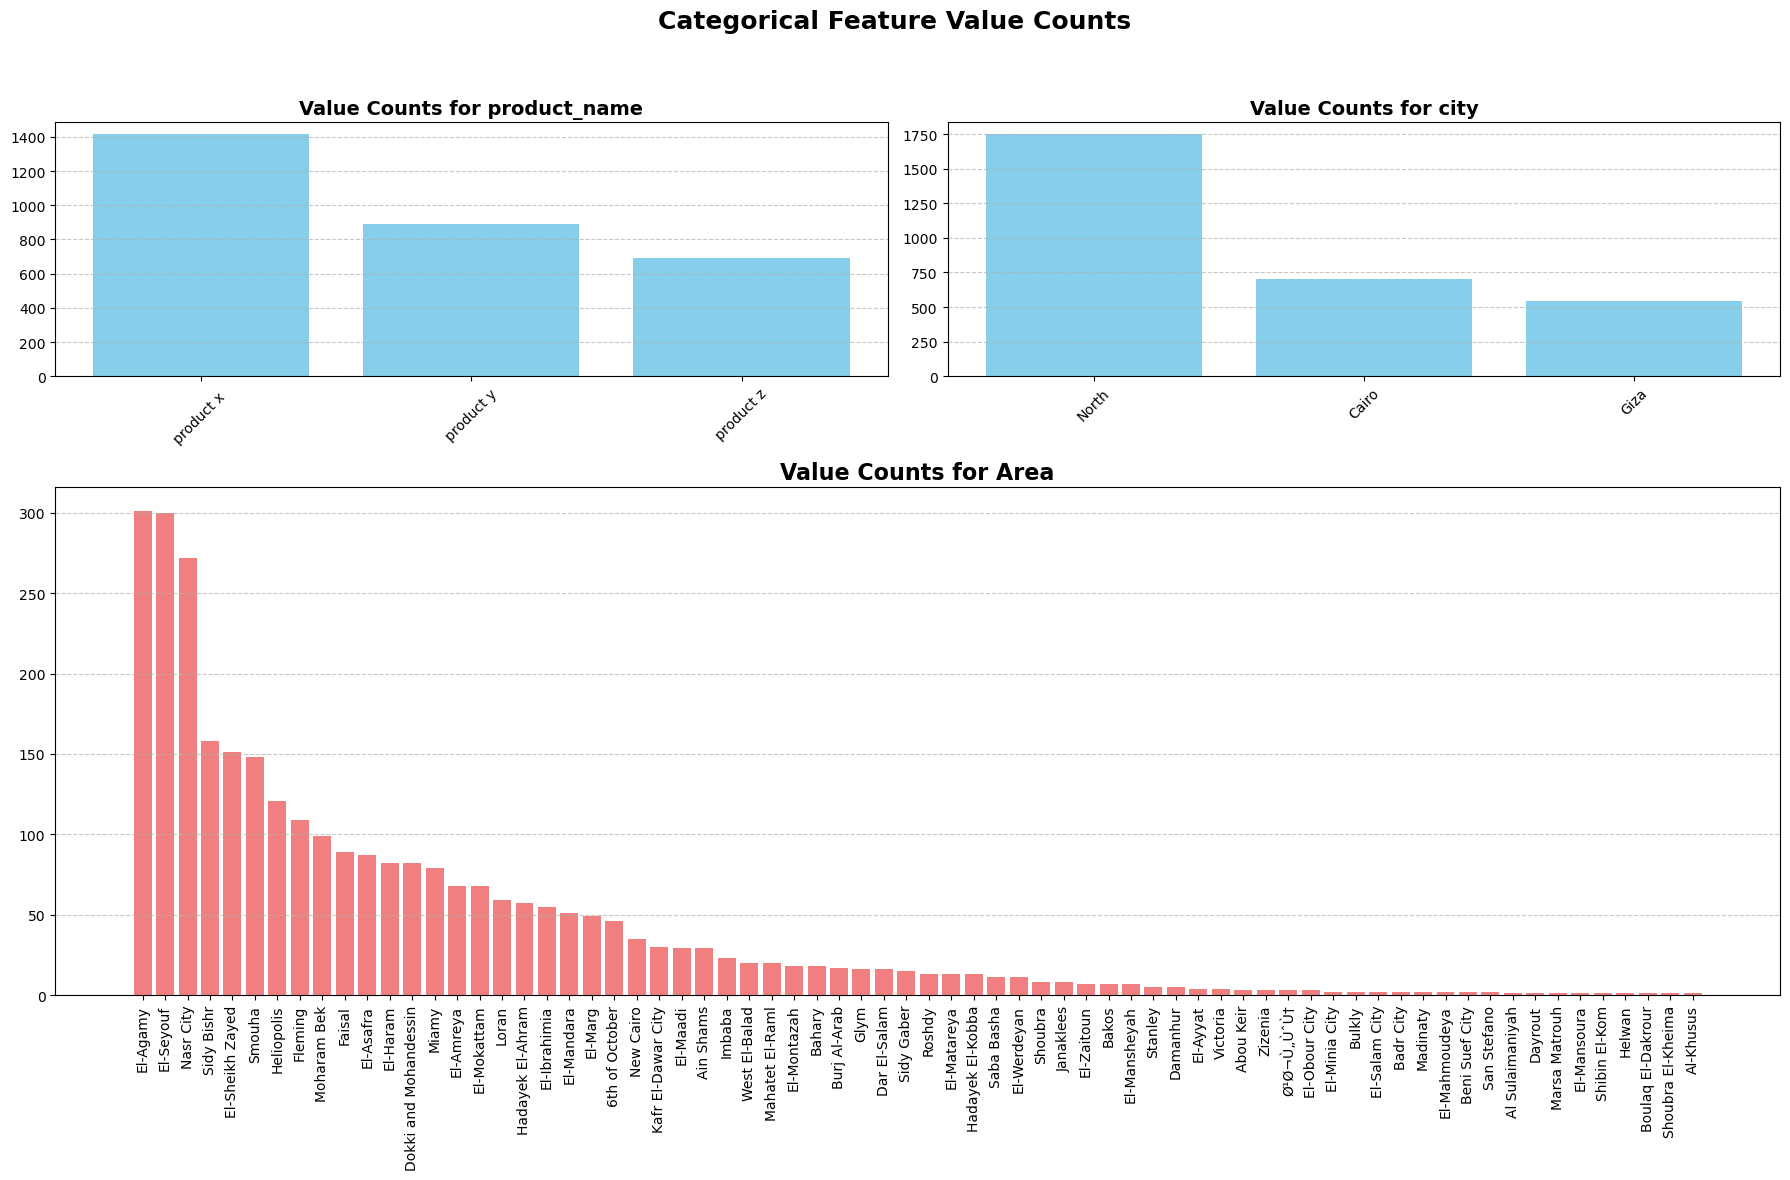

In [30]:
fig = plt.figure(figsize=(18, 12))

gs = fig.add_gridspec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])

for i, col in enumerate(categorical_features.columns[0:3:2]):
    ax = fig.add_subplot(gs[0, i])
    counts = categorical_features[col].value_counts()
    ax.bar(counts.index, counts, color='skyblue')

    ax.set_title(f'Value Counts for {col}', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7, axis="y")

ax_area = fig.add_subplot(gs[1, :])
area_counts = categorical_features['area'].value_counts()
ax_area.bar(area_counts.index, area_counts, color='lightcoral')

ax_area.set_title('Value Counts for Area', fontsize=16, fontweight='bold')

ax_area.tick_params(axis='x', rotation=90)
ax_area.grid(True, linestyle='--', alpha=0.7, axis="y")

fig.suptitle('Categorical Feature Value Counts', fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

Findings:
- __product X__ is almost double the amount of __product Y__.
- City of __North__ is more than double the amount of that of __Cairo__, and __Giza__.
- There are alot of areas, some having Appeared only once.
- There seams to be some kind of corrupt values in __["area"]__

Conclusion:
- Need to be careful around the overrepresented Products and cities since they are part of the forecast.
- Need to fix the corrupted data in the __["area"]__.
- Further analysis is needed in order to use the area feature as part of the training -> Get area Coordinates, calculate major performing areas, and use rpf to get how far an area of the top performing area.

### Data Statistecs, and Test Splitting
- ~~Numerical Statistecs~~
- ~~Categorical Data Values.~~
-       Date Range Exploration
- Test Splitting

In [31]:
date = pd.to_datetime(data["date"])

In [32]:
print(date.min())
print(date.max())

2021-03-31 11:38:58+00:00
2023-01-17 09:24:09+00:00


In [33]:
date.sort_values(inplace=True)
pd.DataFrame(date.reset_index(drop=True)).head(5)

,date
0,2021-03-31 11:38:58+00:00
1,2021-04-30 20:56:54+00:00
2,2021-05-08 14:12:52+00:00
3,2021-05-08 14:12:52+00:00
4,2021-05-22 10:56:31+00:00


Findings:
- The date is stored in  __ISO 8601__ format
- The date range from __2021-03-31__ to __2023-01-17__
- There are gaps between the dates.

Conclusion:
- I will drop the houre and timezone since we care only about the day-month-year
- Date gaps needs to be filled.

### Data Statistecs, and Test Splitting
- ~~Numerical Statistecs~~
- ~~Categorical Data Values.~~
- ~~Date Range Exploration~~
-       Test Splitting

In [34]:
train = data.copy()

### Data Cleaning
1. Drop __["retail price"]__
2. Removing wrong data on __["area"]__, and __["discounts"]__.
3. Cap outliers.
4. Remove Nulls.
5. Calculate __["sales"]__ = __["UnitePrice"]__ * (1 - __["discounts"]__/100) * __["quantity"]__
6. Sort data by __["date"]__, and Drop the houre and timezone information
7. Fill Dates gap

In [35]:
string_cleaner = StringDataCleaner()
outlier_capper = IQROutlierCapping()
area_imputer = GroupImputer()
output_generator = GenerateMultipleOutputs("sales", ["date", "product_name", "city"], strategy="sum", index="date")
date_filler = CreateCompleteDateRange("date", freq="D",filling="zeros")

In [36]:
train = train.drop("retail price",axis=1)
train.loc[train["discount"] < 0, "discount"] = 0
train.loc[:, ["quantity", "UnitePrice", "discount"]] = outlier_capper.fit_transform(train[["quantity", "UnitePrice", "discount"]])
train.loc[:, "area"] = area_imputer.fit_transform(train[["area", "city"]])["area"]
train.loc[:, "sales"] = train["UnitePrice"] * (1 - train["discount"]/100) * train["quantity"]
train = train.sort_values(by="date")
train["date"] = pd.to_datetime(train["date"]).dt.date
train = date_filler.fit_transform(train)

### Feature Engineering
1.      Exploring the new imputed date ranges
2. Make __9__ Targets for forecasts representing each product sold in each city
3. Make __9__ New Features representing discounts for each product in each city
4. Explore general Trend over time using Simple Moving Average, Exponintial moving average, double and triple Exponintial moving averages.
5. Explore Seasonality using priodogram
6. Explore different lags of __discounts__ and sales.

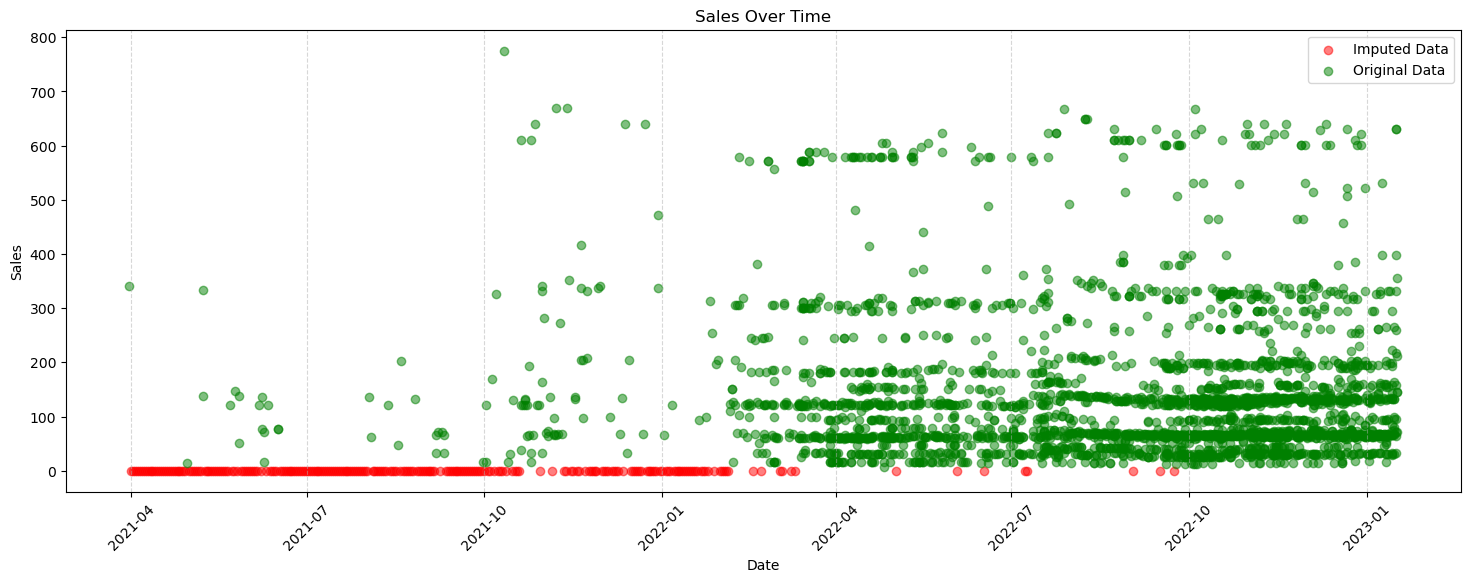

In [37]:
plt.figure(figsize=(18, 6))
plt.title("Sales Over Time")
plt.scatter(train[train["sales"] == 0]["date"], train[train["sales"] == 0]["sales"], c="red", alpha=0.5, label="Imputed Data")
plt.scatter(train[train["sales"] > 0]["date"], train[train["sales"] > 0]["sales"], c="green", alpha=0.5, label="Original Data")
plt.grid(linestyle="--", alpha=0.5, axis="x")
plt.tick_params(axis='x', rotation=45)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

Findings:
- There were a lot of missing data in early 2021
- most of the data is consentrated from around febreuary 2022 
- There are some noticable spikes, maybe there were promotional or marking campain then.

conclusion:
- I will drop the data to February 15th 2022 and consetrate on the period where the bulk of the data are.
- I will impute the very few missing data points (zeros) using backward filling.

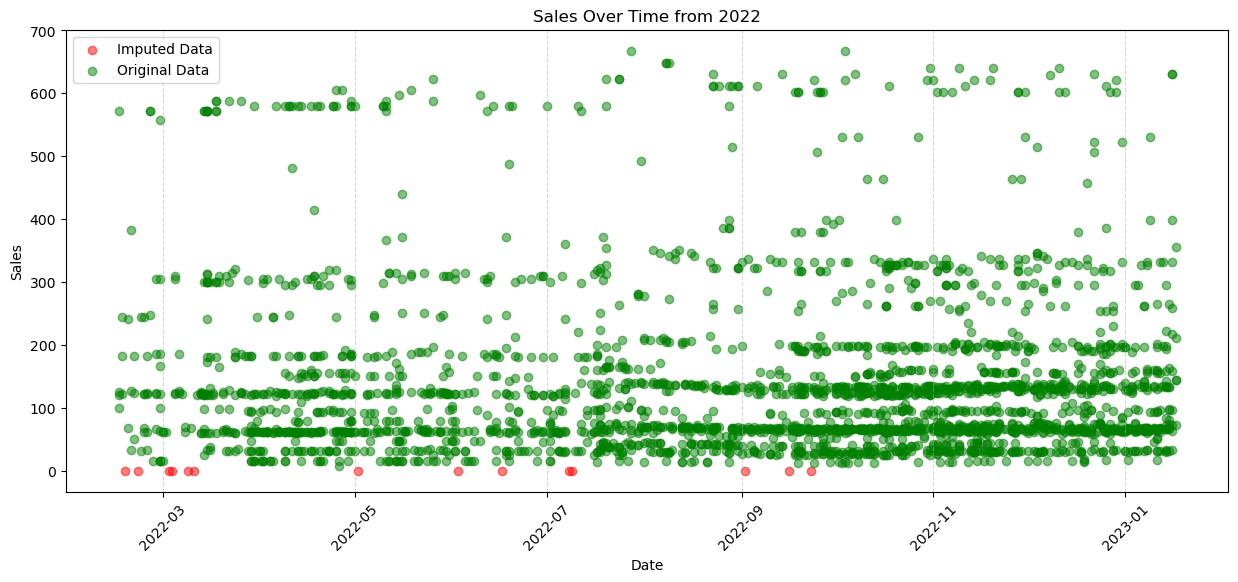

In [38]:
data_from_2022 = train[train["date"] >= "2022-02-15"]

plt.figure(figsize=(15, 6))
plt.title("Sales Over Time from 2022")
plt.scatter(data_from_2022[data_from_2022["sales"] == 0]["date"], data_from_2022[data_from_2022["sales"] == 0]["sales"], c="red", alpha=0.5, label="Imputed Data")
plt.scatter(data_from_2022[data_from_2022["sales"] > 0]["date"], data_from_2022[data_from_2022["sales"] > 0]["sales"], c="green", alpha=0.5, label="Original Data")
plt.grid(linestyle="--", alpha=0.5, axis="x")
plt.tick_params(axis='x', rotation=45)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


### Feature Engineering
1. ~~Exploring the new imputed date ranges~~
2.      Make 9 Targets for forecasts representing each product sold in each city
3. Make __9__ New Features representing discounts for each product in each city
4. Explore general Trend over time using Simple Moving Average, Exponintial moving average, double and triple Exponintial moving averages.
5. Explore Seasonality using priodogram
6. Explore different lags of __discounts__ and sales.

In [39]:
multi_output_generator = GenerateMultipleOutputs("sales", ["product_name", "city"], strategy='sum', index="date")
y = multi_output_generator.fit_transform(data_from_2022).set_index("date")

In [40]:
y

,sales_productx_Cairo,sales_productx_Giza,sales_productx_North,sales_producty_Cairo,sales_producty_Giza,sales_producty_North,sales_productz_Cairo,sales_productz_Giza,sales_productz_North
date,,,,,,,,,
2022-02-15,125.65,0.00,691.52375,0.00,0.0,0.00,0.00,0.000,99.9
2022-02-16,0.00,427.21,0.00000,0.00,0.0,121.60,0.00,0.000,0.0
2022-02-17,0.00,0.00,0.00000,0.00,0.0,0.00,0.00,0.000,0.0
2022-02-18,0.00,0.00,240.53000,0.00,0.0,0.00,0.00,0.000,68.4
2022-02-19,0.00,0.00,509.78000,0.00,0.0,0.00,0.00,0.000,33.3
...,...,...,...,...,...,...,...,...,...
2023-01-13,0.00,331.65,333.63000,0.00,0.0,0.00,0.00,0.000,0.0
2023-01-14,392.04,409.86,331.65000,0.00,156.4,444.34,0.00,294.975,31.5
2023-01-15,265.32,0.00,399.96000,163.02,155.8,0.00,95.85,130.050,0.0


### Feature Engineering
1. ~~Exploring the new imputed date ranges~~
2. ~~Make 9 Targets for forecasts representing each product sold in each city~~
3.      Make __9__ New Features representing discounts for each product in each city
4. Explore general Trend over time using Simple Moving Average, Exponintial moving average, double and triple Exponintial moving averages.
5. Explore Seasonality using priodogram
6. Explore different lags of __discounts__ and sales.

In [41]:
multi_discounts_generator = GenerateMultipleOutputs("discount", ["product_name", "city"], index="date")
discount_features = multi_discounts_generator.fit_transform(data_from_2022).set_index("date")

In [42]:
discount_features.tail(3)

,discount_productx_Cairo,discount_productx_Giza,discount_productx_North,discount_producty_Cairo,discount_producty_Giza,discount_producty_North,discount_productz_Cairo,discount_productz_Giza,discount_productz_North
date,,,,,,,,,
2023-01-15,33.0,0.0,32.50,22.0,16.5,0.0,29.0,28.5,0.000000
2023-01-16,0.0,0.0,31.00,0.0,0.0,24.0,29.0,0.0,28.333333
2023-01-17,0.0,29.0,27.25,0.0,0.0,0.0,0.0,0.0,0.000000


### Feature Engineering
1. ~~Exploring the new imputed date ranges~~
2. ~~Make 9 Targets for forecasts representing each product sold in each city~~
3. ~~Make __9__ New Features representing discounts for each product in each city~~
4.      Explore general Trend over time using Simple Moving Average, Exponintial moving average, double and triple Exponintial moving averages.
5. Explore Seasonality using priodogram
6. Explore different lags of __discounts__ and sales.

First: I will Check the optimal Window size

In [43]:
SMA = cal_moving_average(X=y, span=90)
# plot_sales_and_moving_averages(y, SMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Semple Moving Average 90 Days", label="SML")

In [44]:
SMA = cal_moving_average(X=y, span=60)
#plot_sales_and_moving_averages(y, SMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Semple Moving Average 60 Days", label="SML")

In [45]:
SMA = cal_moving_average(X=y, span=30)
#plot_sales_and_moving_averages(y, SMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Semple Moving Average 30 Days", label="SML")

In [46]:
SMA = cal_moving_average(X=y, span=15)
#plot_sales_and_moving_averages(y, SMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Semple Moving Average 15 Days", label="SML")

Findings:
- Product X and Product Z appear to have more sales volatility and spikes, especially in the North region, which indicates potential seasonality or promotions.
- Product Y is more stable, with fewer dramatic sales spikes, making it a more predictable product.

Conclusion:
- I will stick with a 30 to 60 days window.


Second: I will choose the moving average calculation method

In [47]:
EMA = cal_EMA(y, 60)
#plot_sales_and_moving_averages(y, EMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Exponential Moving Average 60 Days", label="EMA")

In [48]:
EMA = cal_EMA(y, 30)
#plot_sales_and_moving_averages(y, EMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Exponential Moving Average 30 Days", label="EMA")

In [49]:
DEMA = cal_DEMA(X=y, span=60)
#plot_sales_and_moving_averages(y, DEMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Double Exponential Moving Average 60 Days", label="DEMA")

In [50]:
DEMA = cal_DEMA(X=y, span=30)
#plot_sales_and_moving_averages(y, DEMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Double Exponential Moving Average 30 Days", label="DEMA")

In [51]:
TEMA = cal_TEMA(X=y, span=60)
#plot_sales_and_moving_averages(y, TEMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Triple Exponential Moving Average 60 Days", label="TEMA")

In [52]:
TEMA = cal_TEMA(X=y, span=30)
#plot_sales_and_moving_averages(y, TEMA, ["productx", "producty", "productz"], ["Cairo", "Giza", "North"], title="Triple Exponential Moving Average 30 Days", label="TEMA")

Findings:
- __EMA__ is more responsive to the data spikes, specially with a __30__ days window.
- __DEMA__ is even more seponsive to sudden changes in the data without.
- __TEMA__ is too responsive to the data showing very sharp spikes,  not good with a noisy and sudden spikes like in our case.

Conclusion:
- I will use __DEMA__ with a __30__ days window to capture the general sales __Trend__.

### Feature Engineering
1. ~~Exploring the new imputed date ranges~~
2. ~~Make 9 Targets for forecasts representing each product sold in each city~~
3. ~~Make __9__ New Features representing discounts for each product in each city~~
4. ~~Explore general Trend over time using Simple Moving Average, Exponintial moving average, double and triple Exponintial moving averages.~~
5.      Explore Seasonality using priodogram
6. Explore different lags of __discounts__ and sales.

First: Let's plot the periodogram to see potential seasonlities

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

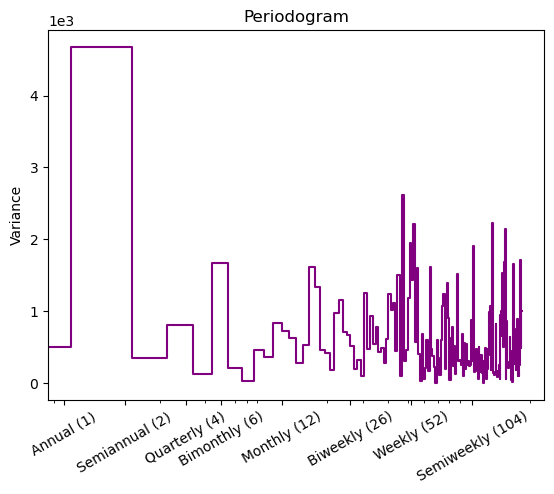

In [53]:
plot_periodogram(y["sales_productx_Giza"])

<Axes: title={'center': 'Seasonal Plot of Sales by Dayofweek'}, xlabel='Dayofweek', ylabel='Sales'>

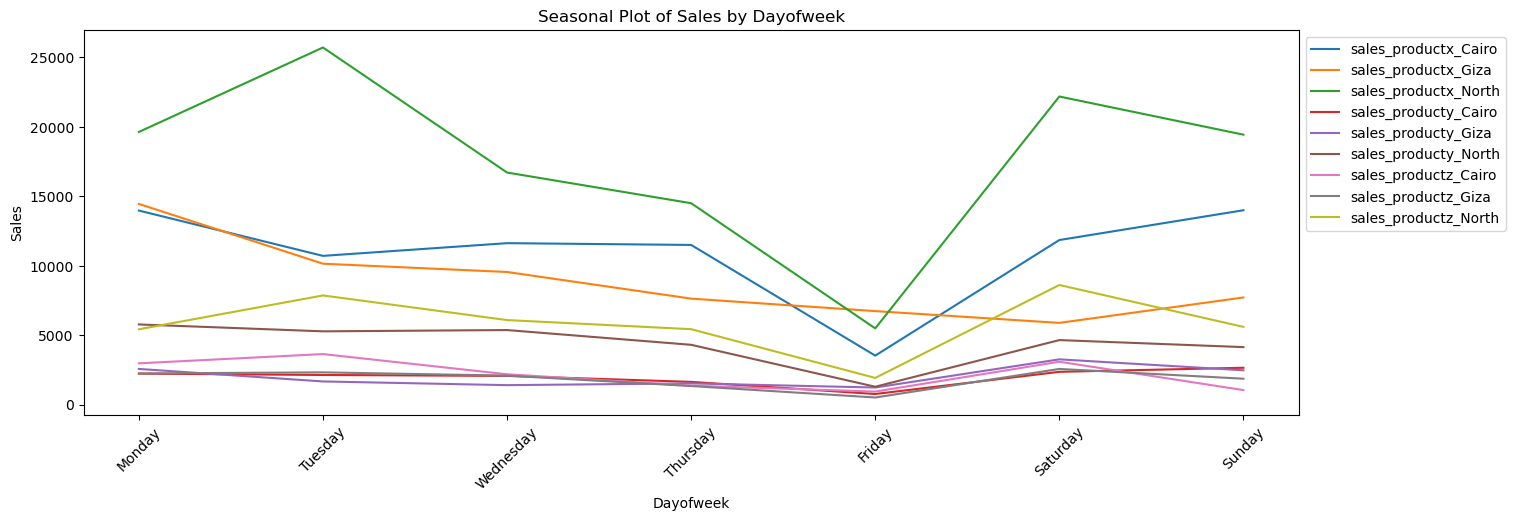

In [54]:
seasonal_plot(y, "dayofweek", "sum")

Findings:
- Sales go up on __Saturday__ "First week day"
- Sales go down on __Friday__ "Weekend"
- Most products follows almost the same pattern.

Conclusion:
- Since the sales go down on the weekend this suggest that the products sold is tied to work materials.
- Will include seasonality indicator for day of the week.

<Axes: title={'center': 'Seasonal Plot of Sales by Dayofyear'}, xlabel='Dayofyear', ylabel='Sales'>

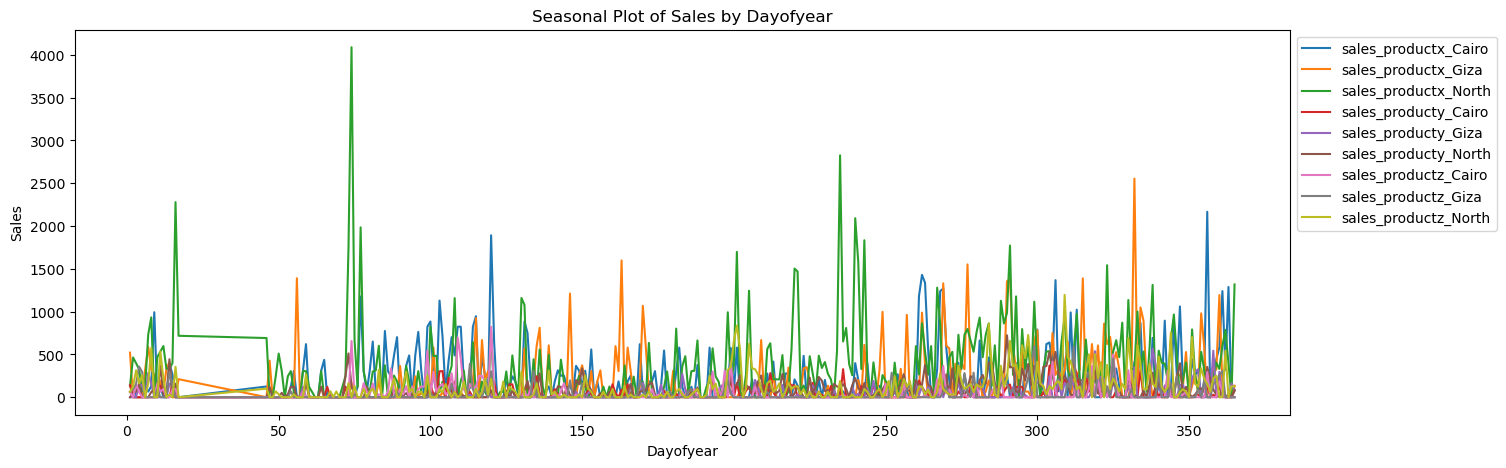

In [55]:
seasonal_plot(y, "dayofyear", "sum")

Findings:
- No clear seasonality is presented over the year
- The beginnging of the data is affected by the imputed zeros to fill time gaps
- there are occisional spiks that maybe an indicator for marketing campains, or high market demand

Conclusion:
- Will not include day of year.

<Axes: title={'center': 'Seasonal Plot of Sales by Month'}, xlabel='Month', ylabel='Sales'>

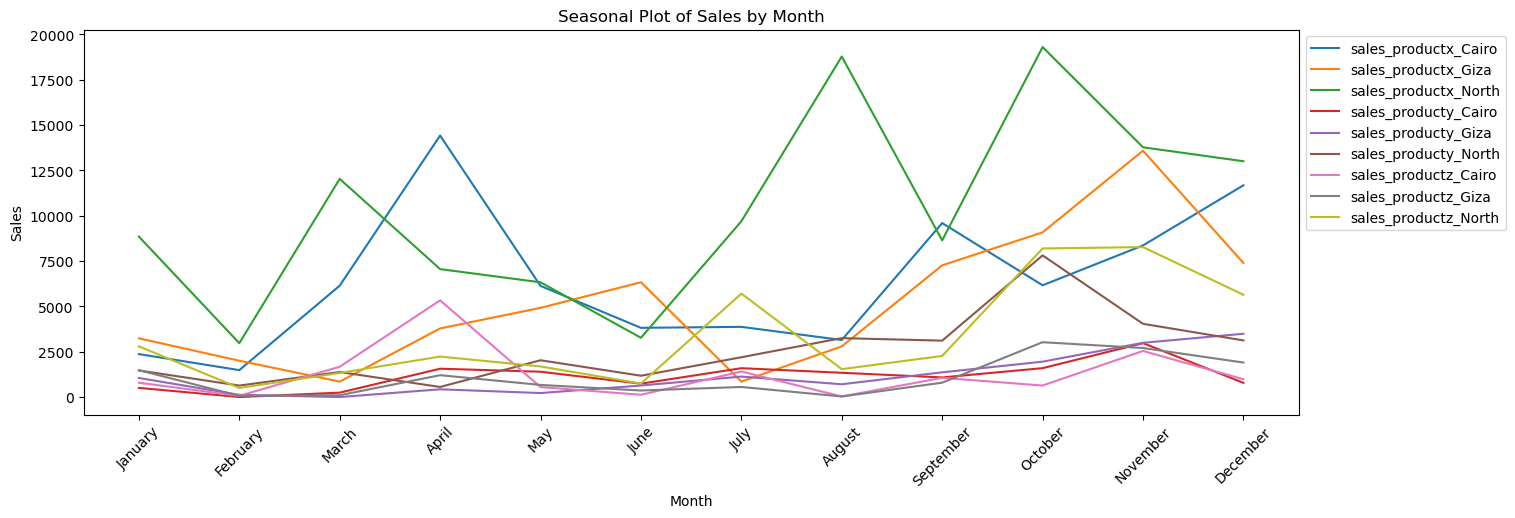

In [56]:
seasonal_plot(y, "month", "sum")

Findings:
- The sales start of low and starts to spike at __March__ and again at __August__ and __October__
- All the lines follow reletavily the same pattern.

Conclusion: 
- Will use Fourier Features to capture the seasonality over the months

<Axes: title={'center': 'Seasonal Plot of Sales by Day'}, xlabel='Day', ylabel='Sales'>

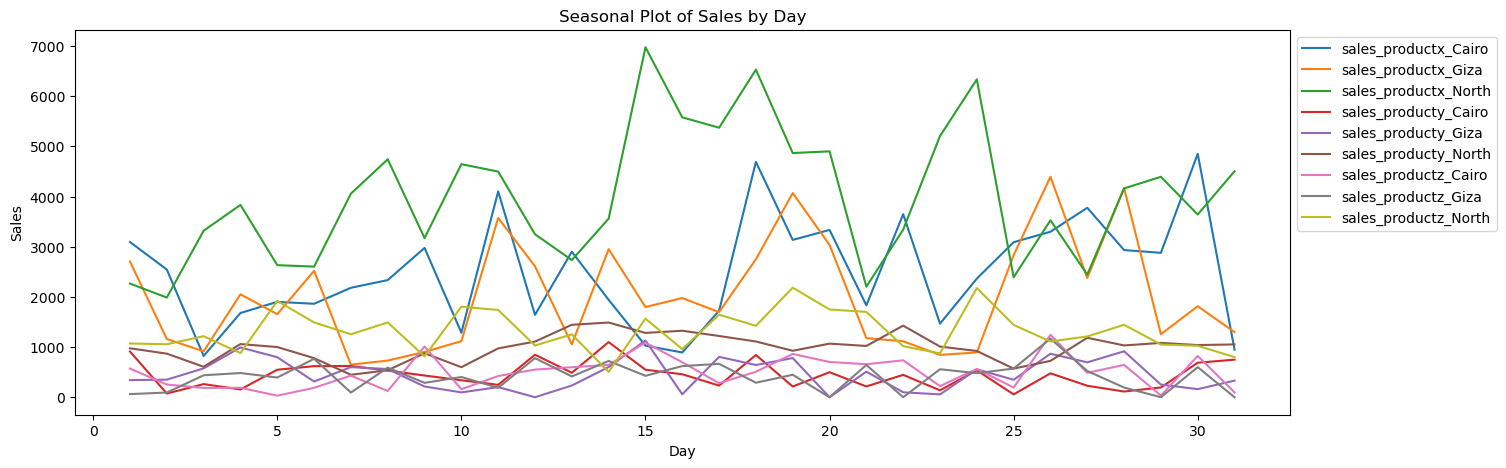

In [57]:
seasonal_plot(y, "day", "sum")

<Axes: title={'center': 'Seasonal Plot of Sales by Week'}, xlabel='Week', ylabel='Sales'>

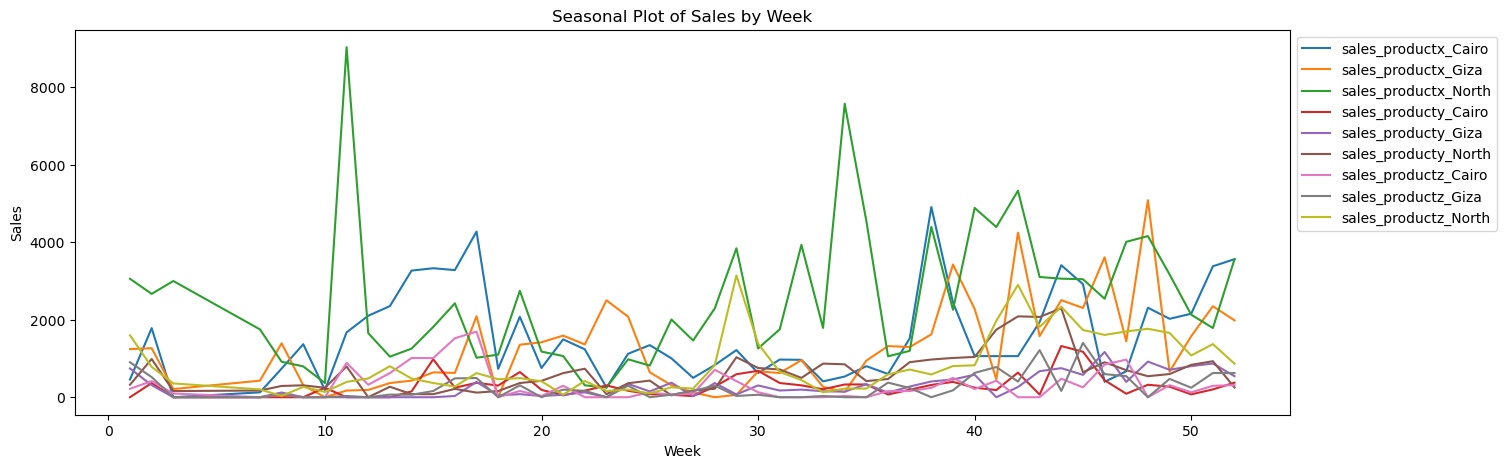

In [58]:
seasonal_plot(y, "week", "sum")

<Axes: title={'center': 'Seasonal Plot of Sales by Semiweekly'}, xlabel='Semiweekly', ylabel='Sales'>

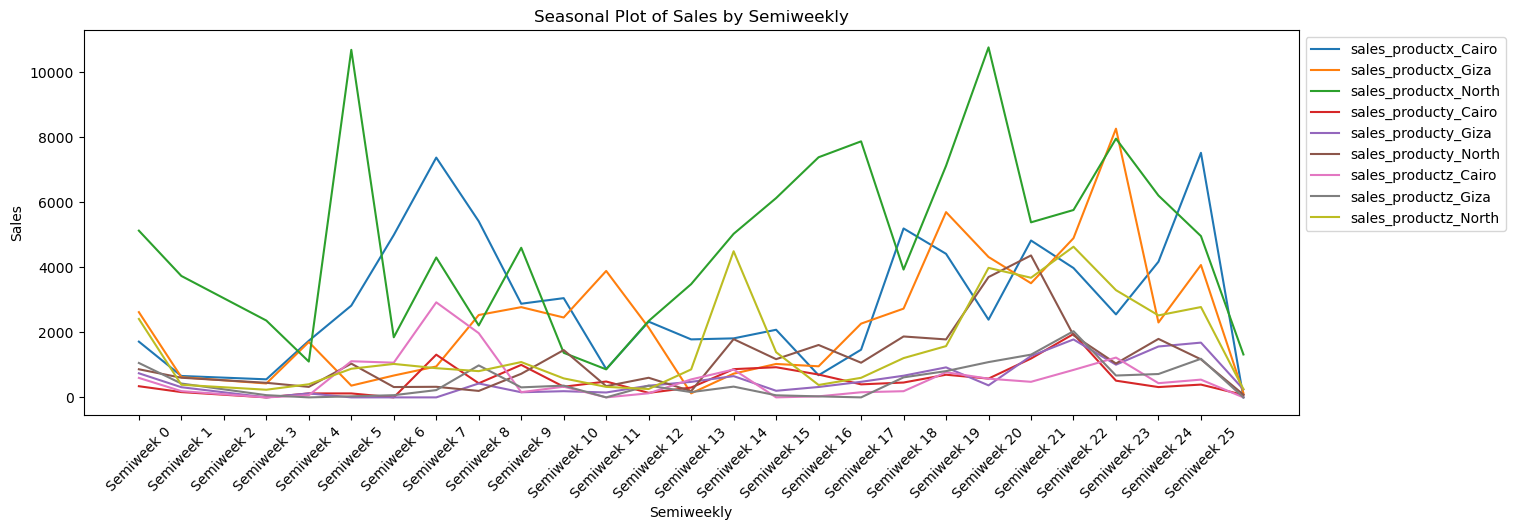

In [59]:
seasonal_plot(y, "semiweekly", "sum")

Findings:
- The __Month__ and __Week__ seasonality looks almost random with few peaks.
- The __Semiweekly__ seasonlai is almost identical to the __Weekly__ seasonalit, there is no reason to include both.

Conclusion:
- For now I will ignore the __Monthly__, __Weekly__ data -> Try adding Fourier Faature.
- I will not use the __Semiweekly__ seasonality at all.

### Feature Engineering
1. ~~Exploring the new imputed date ranges~~
2. ~~Make 9 Targets for forecasts representing each product sold in each city~~
3. ~~Make __9__ New Features representing discounts for each product in each city~~
4. ~~Explore general Trend over time using Simple Moving Average, Exponintial moving average, double and triple Exponintial moving averages.~~
5. ~~Explore Seasonality using priodogram~~
6.      Explore different lags of __discounts__ and sales.

First Lets see How Priveous sales affect the current sales.

In [60]:
#for col in y.columns:
    #plot_correlogram(y, col, 14)

Findings:
- all products have strong correlation with last 1 or 2 days in the past
- all products have strong correlation with a weekly lags around 7 and 14 days.

Conclustion:
- I will use lags 1 and 7

Second: Let's Explore the affect of previous discounts on current sales.

In [61]:
#for i in range(0, y.shape[1]):
    #plot_lags(y[y.columns[i]], discount_features[discount_features.columns[i]], 4, 1)

Findings: 
- Most Sales is affected by past discounts, encourging customers to buy
- Some products carry that effect for 2, 3, and some times even 4 days thou rare
- Intresingly the product Z sales in North seams to falloff with even with discounts

Conclusion:
- I will add 2 days lag from the discounts as features.

### Modling
1.      Ready The X and y.
2. Try Simple models ARIMA, SARIMA.
3. Try Machine Learning models LinearRegression, RandomForest, XGBoost.
4. Hyberparameter tuning and reducing the overfitting.
5. Predicting the next 10 days.

In [62]:
y.head(1)

,sales_productx_Cairo,sales_productx_Giza,sales_productx_North,sales_producty_Cairo,sales_producty_Giza,sales_producty_North,sales_productz_Cairo,sales_productz_Giza,sales_productz_North
date,,,,,,,,,
2022-02-15,125.65,0.0,691.52375,0.0,0.0,0.0,0.0,0.0,99.9


In [63]:
# Trend Feature
X = cal_DEMA(y, 30)

# Seasonality indicator for weekly patterns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X["week"] = pd.to_datetime(y.index).day_of_week
X = add_day_of_week_onehot(X, "week", True).drop("week",axis=1)

# Seasonality Fourier Features for monthly patterns
X["month"] = pd.to_datetime(y.index).month
X = create_fourier_features(X, "month", 12, 3).drop("month", axis=1)

# Lag features for sales
lag_feature = create_lag_features(y, [1, 7])
X = pd.concat((X, lag_feature), axis=1)

# Lag features for discounts
discount_lagged = create_lag_features(discount_features, [1, 2])
X = pd.concat((X, discount_lagged), axis=1)

# dropping the null values after lagging the data
nan_rows_X = X.isna().any(axis=1)
X = X.loc[~nan_rows_X].copy()
y = y.loc[~nan_rows_X].copy()

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

### Modling
1. ~~Ready The X and y.~~
2.      Try Simple models ARIMA, SARIMA.
3. Try Machine Learning models LinearRegression, RandomForest, XGBoost.
4. Hyberparameter tuning and reducing the overfitting.
5. Predicting the next 10 days.

In [65]:
arima_model = ARIMAModel(order=(1, 1, 1))
multi_output_arima = MultiOutputRegressor(arima_model)
multi_output_arima.fit(X_train.index, y_train)
evaluate_model(multi_output_arima, X_train, X_test, y_train, y_test)

Training MAE: 188.27122551966255
Testing MAE: 178.95172228206454
Training R-squared: -0.974172320836107
Testing R-squared: -0.26224958892733546


f:\projects\ML_DL\HML3\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [66]:
sarima_model = SARIMAModel(order=(1, 1, 1))
multi_output_sarima = MultiOutputRegressor(sarima_model)
multi_output_sarima.fit(X_train.index, y_train)
evaluate_model(multi_output_sarima, X_train, X_test, y_train, y_test)

Training MAE: 279.992457415142
Testing MAE: 211.5429910278385
Training R-squared: -4.220292388389783
Testing R-squared: -0.677140159731459


### Modling
1. ~~Ready The X and y.~~
2. ~~Try Simple models ARIMA, SARIMA.~~
3.      Try Machine Learning models LinearRegression, RandomForest, XGBoost.
4. Hyberparameter tuning and reducing the overfitting.
5. Predicting the next 10 days.

In [67]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
evaluate_model(lin_reg, X_train, X_test, y_train, y_test)

Training MAE: 90.90215570813318
Testing MAE: 275.441629854454
Training R-squared: 0.5427498615336699
Testing R-squared: -1.3833373852520905


In [68]:
net_reg = ElasticNet()
net_reg.fit(X_train, y_train)
evaluate_model(net_reg, X_train, X_test, y_train, y_test)

Training MAE: 93.44208606513212
Testing MAE: 206.1853391486081
Training R-squared: 0.4950378964697294
Testing R-squared: -0.3875805440899447


In [69]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
evaluate_model(forest_reg, X_train, X_test, y_train, y_test)

Training MAE: 40.26824807107513
Testing MAE: 166.2814078172691
Training R-squared: 0.8846295537205934
Testing R-squared: -0.015063494343854086


## <----Addon to the task---->


In [70]:
import numpy as np

# Apply log transform on non-zero values only to avoid -inf
y_train_log = np.log1p(y_train)  # Use log1p to handle zero values (log(1 + x))
y_test_log = np.log1p(y_test)

In [71]:
sample_weights = np.where(np.any(y_train_log == 0, axis=1), 1, 5)

In [72]:
from sklearn.preprocessing import StandardScaler

numerical_cols = [col for col in X_train.columns if not col.startswith("day_of_week") and not col.startswith("sin_month") and not col.startswith("cos_month")]
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the numerical columns
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [73]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Define parameters for LightGBM
lgb_params = {
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'max_depth': 6,
    'min_child_weight': 5,
    'reg_alpha': 1,
    'reg_lambda': 2,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Initialize primary and secondary models wrapped with MultiOutputRegressor
primary_model = MultiOutputRegressor(LGBMRegressor(**lgb_params))
secondary_model = MultiOutputRegressor(LGBMRegressor(**lgb_params))

# Step 1: Train the primary model on the log-transformed target
primary_model.fit(X_train_scaled, y_train_log, sample_weight=sample_weights)

# Step 2: Predict with the primary model and calculate residuals
y_pred_train_stage1 = primary_model.predict(X_train_scaled)
y_pred_test_stage1 = primary_model.predict(X_test_scaled)

# Calculate residuals (difference between log-transformed target and primary predictions)
residuals_train = y_train_log - y_pred_train_stage1
residuals_test = y_test_log - y_pred_test_stage1

# Step 3: Train the secondary model on residuals to capture additional patterns
secondary_model.fit(X_train_scaled, residuals_train, sample_weight=sample_weights)

# Step 4: Combine predictions from both models and inverse-transform to original scale
y_pred_train_final = np.expm1(y_pred_train_stage1 + secondary_model.predict(X_train_scaled))
y_pred_test_final = np.expm1(y_pred_test_stage1 + secondary_model.predict(X_test_scaled))

train_mae = mean_absolute_error(np.expm1(y_train_log), y_pred_train_final)
test_mae = mean_absolute_error(np.expm1(y_test_log), y_pred_test_final)

train_r2 = r2_score(np.expm1(y_train_log), y_pred_train_final)
test_r2 = r2_score(np.expm1(y_test_log), y_pred_test_final)

print(f"Training MAE: {train_mae}")
print(f"Testing MAE: {test_mae}")
print(f"Training R-squared: {train_r2}")
print(f"Testing R-squared: {test_r2}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 247, number of used features: 57
[LightGBM] [Info] Start training from score 3.260853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Conclusion: 
- XGBoost and LightGBM looks the most promissing, but need parameter tuning to reduce the overfitting effect

### Modling
1. ~~Ready The X and y.~~
2. ~~Try Simple models ARIMA, SARIMA.~~
3. ~~Try Machine Learning models LinearRegression, ElasticNet, RandomForest, XGBoost.~~
4.      Hyberparameter tuning and reducing the overfitting.
5. Predicting the next 10 days.

## <---Takes about 45 min to run---->

In [74]:
'''
gbr = GradientBoostingRegressor(random_state=42)
gbr = MultiOutputRegressor(gbr)

param_grid = {
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__n_estimators': [100, 300, 500],
    'estimator__max_depth': [3, 4, 5, 6],
    'estimator__subsample': [0.8, 0.9, 1.0],
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(gbr, param_grid, cv=tscv, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)
evaluate_model(grid_search.best_estimator_, X_train, X_test, y_train, y_test)

'''

"\ngbr = GradientBoostingRegressor(random_state=42)\ngbr = MultiOutputRegressor(gbr)\n\nparam_grid = {\n    'estimator__learning_rate': [0.01, 0.05, 0.1],\n    'estimator__n_estimators': [100, 300, 500],\n    'estimator__max_depth': [3, 4, 5, 6],\n    'estimator__subsample': [0.8, 0.9, 1.0],\n}\n\ntscv = TimeSeriesSplit(n_splits=5)\n\ngrid_search = GridSearchCV(gbr, param_grid, cv=tscv, scoring='neg_mean_absolute_error')\n\ngrid_search.fit(X_train, y_train)\nevaluate_model(grid_search.best_estimator_, X_train, X_test, y_train, y_test)\n\n"

Conclusion:
- The best set of parameters is learning_rate = 0.01, n_estimators=25, max_depth=3, subsample=0.8
- Still there is senificat amount of overfitting.

### Modling
1. ~~Ready The X and y.~~
2. ~~Try Simple models ARIMA, SARIMA.~~
3. ~~Try Machine Learning models LinearRegression, ElasticNet, RandomForest, XGBoost.~~
4. ~~Hyberparameter tuning and reducing the overfitting.~~
5.      Predicting the next 10 days.

In [75]:
'''

def generate_predictions_for_next_days(model, X, y, discount_features, num_days=10):
    # Get the last known date from the index
    last_date = pd.to_datetime(X.index[-1])

    # Start with the last known observation (as a DataFrame/Series with feature names)
    last_observation_X = X.iloc[-1, :].copy()

    # Initialize an empty DataFrame to store predictions
    predictions_df = pd.DataFrame(index=pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days),
                                  columns=y.columns)

    for i in range(num_days):
        # Prepare last observation for prediction
        last_observation_X_df = pd.DataFrame(last_observation_X.values.reshape(1, -1), columns=last_observation_X.index)

        # Predict the next day based on the current last observation
        next_day_pred = model.predict(last_observation_X_df)[0]

        # Store the prediction for each product-city combination
        predictions_df.iloc[i] = next_day_pred

        # Update the date to the next day
        last_date += pd.Timedelta(days=1)

        # Update features for the next day based on the new date
        last_observation_X = update_features_for_next_day(last_observation_X, next_day_pred, discount_features, last_date, y)

    return predictions_df

def update_features_for_next_day(last_observation_X, next_day_pred, discount_features, next_date, y):
    """
    Update the features (like lags or seasonal features) for the next day using the new date (next_date).
    """
    # Update the lag features for sales and discounts using the create_lag_features function
    y.loc[next_date] = next_day_pred  # Add new prediction to y
    lagged_sales = create_lag_features(y, lags=[1, 7])

    # Merge the updated lagged features back into the last_observation_X
    last_observation_X.update(lagged_sales.iloc[-1])

    # Update lag features for discounts (only lag 1 and lag 2)
    discount_lagged = create_lag_features(discount_features, lags=[1, 2])
    last_observation_X.update(discount_lagged.iloc[-1])

    # Update seasonality features (day of the week)
    if "week" in last_observation_X.index:
        last_observation_X["week"] = next_date.weekday()  # Get day of the week (0=Monday, 6=Sunday)

    # Fourier features for monthly seasonality (update existing Fourier features)
    last_observation_X = update_existing_fourier_features(last_observation_X, next_date.month, 12, 3)

    return last_observation_X

def update_existing_fourier_features(df, month_value, period, n_harmonics):
    """
    Update the existing Fourier features for the given month_value.
    Make sure no new columns are added, only update existing Fourier features.
    """
    for i in range(1, n_harmonics + 1):
        if f'sin_month_{i}' in df.index:  # Only update existing columns
            df[f'sin_month_{i}'] = np.sin(2 * np.pi * i * month_value / period)
        if f'cos_month_{i}' in df.index:  # Only update existing columns
            df[f'cos_month_{i}'] = np.cos(2 * np.pi * i * month_value / period)

    return df

# Generate predictions for the next 10 days
next_10_days_predictions = generate_predictions_for_next_days(multi_output_LightDB, X, y, discount_features, num_days=10)

next_10_days_predictions.to_csv("predictions.csv")
'''

'\n\ndef generate_predictions_for_next_days(model, X, y, discount_features, num_days=10):\n    # Get the last known date from the index\n    last_date = pd.to_datetime(X.index[-1])\n\n    # Start with the last known observation (as a DataFrame/Series with feature names)\n    last_observation_X = X.iloc[-1, :].copy()\n\n    # Initialize an empty DataFrame to store predictions\n    predictions_df = pd.DataFrame(index=pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days),\n                                  columns=y.columns)\n\n    for i in range(num_days):\n        # Prepare last observation for prediction\n        last_observation_X_df = pd.DataFrame(last_observation_X.values.reshape(1, -1), columns=last_observation_X.index)\n\n        # Predict the next day based on the current last observation\n        next_day_pred = model.predict(last_observation_X_df)[0]\n\n        # Store the prediction for each product-city combination\n        predictions_df.iloc[i] = next_day_

## <----Addon to the task---->

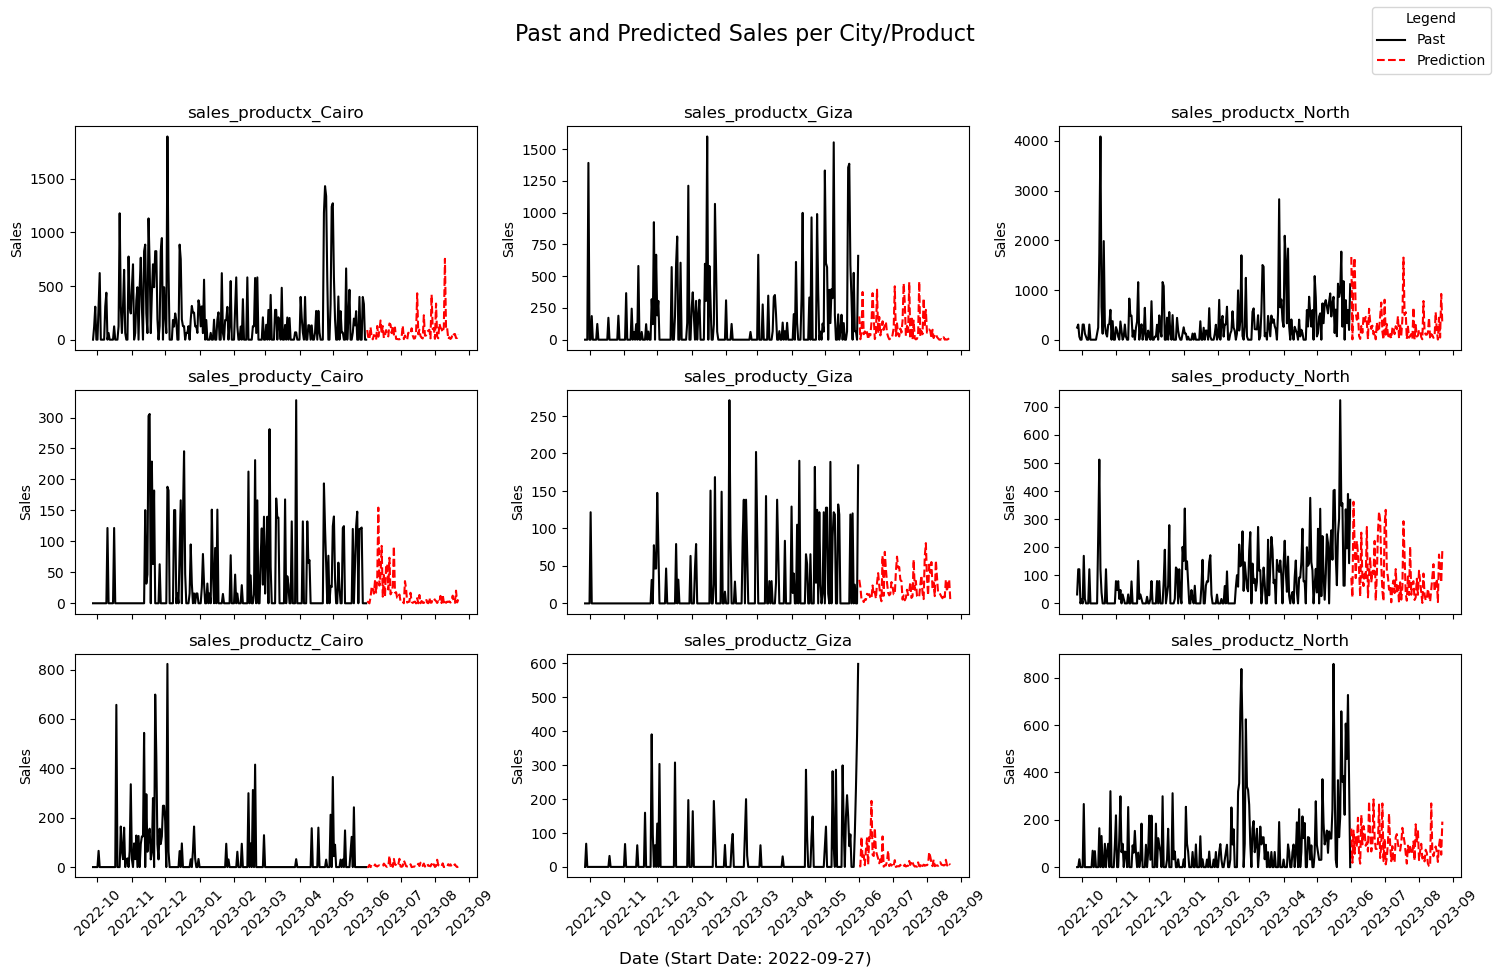

In [76]:
plot_past_and_predictions(np.expm1(y_train_log), y_pred_test_final, "2022-09-27", target_names=y_train.columns)

# Conclusion
* Data Limitaion:  
    * The data have very huge time gaps between observations having days with no sales records at all
    * Not all recoreded days have all products sold in each city, that further increase data sparsity
    * The year 2021 and early 2022 had almost no records at all that forced me to drop them and lose alot of usfull information
    * The gaps in the data made some drastice sales differences that affected the trend and seasonality capturing introducing huge spikes with no clear explanation.
    * The city "North" and product X were present almost double the amount of other cities and products.

* Future work:
    * Try gathring more data about the sales to make up the gaps
    * Try Using analyising the area to see if different areas follow different patterns
    * Try even more models to make more accurate forecasting -> hybred models maybe an ARIMA and XGBoost together trained on different features.
    * Gather more data about the huge sales spikes in some cases, maybe there were marketing campains.
